In [1]:
import sys
import os
import pandas as pd

current_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.abspath(os.path.join(current_dir, '..', '..'))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"La root del progetto è: {project_root}")

La root del progetto è: c:\Users\David\Desktop\studio\bayes_naive\sms_spam


In [ ]:
import pandas as pd

import io
from email import parser as email_parser
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from app.utils.preprocessor import TextPreprocessor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from app.utils.rawEmailToFeaturesTransformer import RawEmailToFeaturesTransformer
from app.utils.seriesToRavel import series_to_ravel

import matplotlib.pyplot as plt

import joblib


In [3]:
emailsSpam = pd.read_csv('./dati/email_origin.csv')

In [4]:
emailsSpam.head()

,label,origin
0,1,Return-Path: <RickyAmes@aol.com>\nReceived: fr...
1,0,Return-Path: <bounce-debian-mirrors=ktwarwic=s...
2,1,Return-Path: <7stocknews@tractionmarketing.com...
3,1,Return-Path: <vqucsmdfgvsg@ruraltek.com>\nRece...
4,1,Return-Path: <dcube@totalink.net>\nReceived: f...


In [5]:
def extract_raw_features(raw_email_text: str) -> dict:
    """
    Estrae le feature strutturali e il testo pulito dal contenuto RAW di un'email.
    """
    msg = email_parser.Parser().parse(io.StringIO(raw_email_text))
    
    features = {
        'subject': msg['subject'] or '',
        'from_header': msg['from'] or '',
        'content_type': msg.get_content_type(),
        'body_text': '',
        'is_html': False
    }

    body = ''
    if msg.is_multipart():
        for part in msg.walk():
            ctype = part.get_content_type()
            cdisp = part.get('Content-Disposition')

            if ctype == 'text/plain' and not cdisp:
                body += part.get_payload(decode=True).decode(errors='ignore')
            elif ctype == 'text/html':
                features['is_html'] = True
    else:
        body = msg.get_payload(decode=True).decode(errors='ignore')

    features['body_text'] = body
    
    from_domain_match = re.search(r'@([\w\.-]+)', features['from_header'])
    features['from_domain'] = from_domain_match.group(1).lower() if from_domain_match else 'unknown'
    
    features['body_length'] = len(body)
    
    return features

In [6]:
X = emailsSpam['origin']
y = emailsSpam['label']

In [7]:
X

0        Return-Path: <RickyAmes@aol.com>\nReceived: fr...
1        Return-Path: <bounce-debian-mirrors=ktwarwic=s...
2        Return-Path: <7stocknews@tractionmarketing.com...
3        Return-Path: <vqucsmdfgvsg@ruraltek.com>\nRece...
4        Return-Path: <dcube@totalink.net>\nReceived: f...
                               ...                        
75414    Return-Path: <Merrill8783@168city.com>\nReceiv...
75415    Return-Path: <Merrill8783@168city.com>\nReceiv...
75416    Return-Path: <r-help-bounces@stat.math.ethz.ch...
75417    Return-Path: <r-help-bounces@stat.math.ethz.ch...
75418    Return-Path: <the00@plg.uwaterloo.ca>\nReceive...
Name: origin, Length: 75419, dtype: object

In [8]:
y.head()

0    1
1    0
2    1
3    1
4    1
Name: label, dtype: int64

In [9]:
y.value_counts()

label
1    50199
0    25220
Name: count, dtype: int64

ora eseguo il train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [11]:
print(X_train.shape)
print(X_test.shape)

(60335,)
(15084,)


In [12]:
X_train

23894    Return-Path: <darnell@grillini.com>\nReceived:...
49469    Return-Path: <dwdiamondcomputersm@diamondcompu...
56305    Return-Path: <barclaysbankb@aim.com>\nReceived...
65246    Return-Path: <r-help-bounces@stat.math.ethz.ch...
6013     Return-Path: <nobody@server.fastbox.info>\nRec...
                               ...                        
21243    Return-Path: <acm189991@hotmail.com>\nReceived...
45891    Return-Path: <jmandymoorethailand@goldenalaska...
42613    Return-Path: <eir@ins-th.com>\nReceived: from ...
43567    Return-Path: <samba-cvs-bounces+ktwarwic=speed...
68268    Return-Path: <contactus@activeroute.com>\nRece...
Name: origin, Length: 60335, dtype: object

In [ ]:
text_transformer = Pipeline([
    ('extract_col', FunctionTransformer(series_to_ravel, validate=False)),
    ('pulizia_punteggiatura', TextPreprocessor()),
    ('tfidf', TfidfVectorizer(stop_words='english', token_pattern=r'\b\w+\b'))
])

# domain_transformer = Pipeline(steps=[
#     ('raggruppa_domini', DomainGrouper()),
#     ('ohe', OneHotEncoder(handle_unknown='ignore'))
# ])

preprocessor = ColumnTransformer(
    transformers=[
        ('text_content_subject', text_transformer, ['subject']),
        ('text_content_body_text', text_transformer, ['body_text']),
        ('categorical', OneHotEncoder(handle_unknown='ignore'), ['content_type', 'is_html']),
        # ('domain', domain_transformer, ['from_domain']),
        ('numeric', MinMaxScaler(), ['body_length'])
    ],
    remainder='drop'
)

final_pipeline = Pipeline(steps=[
    ('raw_to_features', RawEmailToFeaturesTransformer()),
    ('preprocessor', preprocessor),
    ('nb', MultinomialNB())
])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [16]:
X_train.shape

(60335,)

In [17]:
X_test.shape

(15084,)

In [18]:
param_grid = {
    'preprocessor__text_content_subject__tfidf__ngram_range': [(1, 1)], # , (1, 2)
    'preprocessor__text_content_subject__tfidf__max_features': [5000], # , 10000, None
    'preprocessor__text_content_body_text__tfidf__ngram_range': [(1, 1)], # , (1, 2)
    'preprocessor__text_content_body_text__tfidf__max_features': [5000], # , 10000, None
    'nb__alpha': [0.1], # , 0.5, 1.0
    # 'nb__error_score': ['raise']
}

grid_search = GridSearchCV(
    final_pipeline,
    param_grid,
    cv=2,
    scoring='f1',
    n_jobs=-1
)



In [19]:
type(X_train)

pandas.core.series.Series

In [20]:
grid_search.fit(X_train, y_train)

,estimator,Pipeline(step...inomialNB())])
,param_grid,"{'nb__alpha': [0.1], 'preprocessor__text_con...xt__tfidf__max_features': [5000], 'preprocessor__text_con...ext__tfidf__ngram_range': [(1, ...)], 'preprocessor__text_con...ct__tfidf__max_features': [5000], ...}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,2
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,raw_column_name,'origin'


In [21]:
grid_search.best_score_

np.float64(0.9828883676286702)

In [22]:
model = grid_search.best_estimator_

In [23]:
X_train_pred = model.predict(X_train)
X_test_pred = model.predict(X_test)


In [24]:
def evaluate_predictions(predictions, y_true):
    cm = confusion_matrix(y_true, predictions)
    class_names = ['Classe 0 (ham)', 'Classe 1 (spam)']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d')
    plt.show()
    
    print(classification_report(y_true, predictions, target_names=class_names))
    print(cm)
    

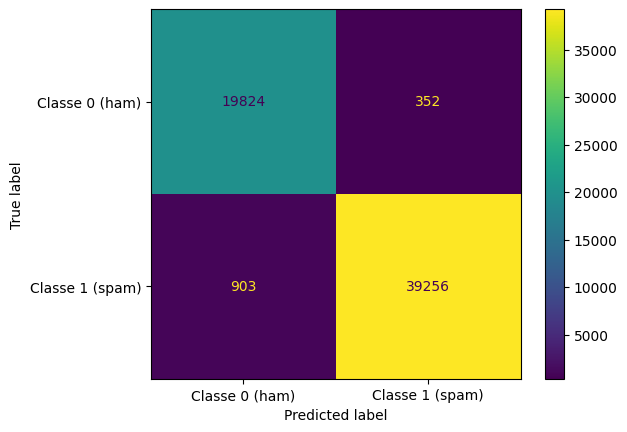

                 precision    recall  f1-score   support

 Classe 0 (ham)       0.96      0.98      0.97     20176
Classe 1 (spam)       0.99      0.98      0.98     40159

       accuracy                           0.98     60335
      macro avg       0.97      0.98      0.98     60335
   weighted avg       0.98      0.98      0.98     60335

[[19824   352]
 [  903 39256]]


In [25]:
evaluate_predictions(X_train_pred, y_train)

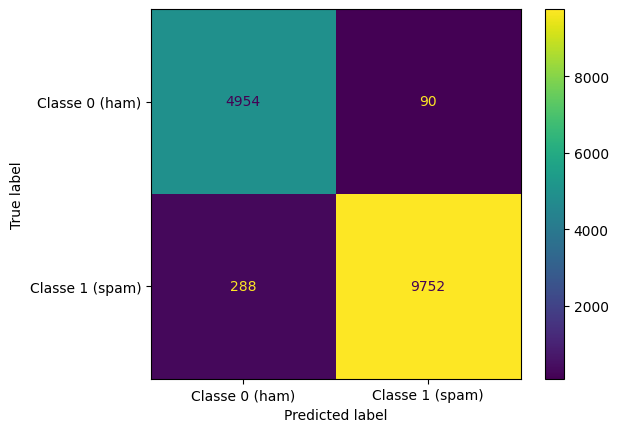

                 precision    recall  f1-score   support

 Classe 0 (ham)       0.95      0.98      0.96      5044
Classe 1 (spam)       0.99      0.97      0.98     10040

       accuracy                           0.97     15084
      macro avg       0.97      0.98      0.97     15084
   weighted avg       0.98      0.97      0.98     15084

[[4954   90]
 [ 288 9752]]


In [26]:
evaluate_predictions(X_test_pred, y_test)

date le prestazioni molto alte ritengo che al momento non sia necessario creare il sistema di raggruppamento

In [27]:
joblib.dump(model, '../mail_spam_pipeline.joblib')
print("Pipeline salvata come 'mail_spam_pipeline.joblib'")

Pipeline salvata come 'mail_spam_pipeline.joblib'
